In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Por ahora hemos visto que:

Se necesita separar de forma aleatoria en datos de entrenamiento y testeo para poder evaluar performance del algoritmo.
Existen diversas métricas para evaluar rendimiento, y elegimos la nuestra según las caracteristicas de nuestro problema.
Es útil apoyar la evaluación con visualizaciones de errores, como por ejemplo scatterplots de residuales.
Sin embargo nuestro método hasta ahora tiene una falla. Este depende de la forma en que fueron elegidos nuestros datos de forma aleatoria:

Podemos tener suerte y caer en un train set y test set que sea ideal para nuestro modelo.
Podemos tener pésima performance con esa separación de datos pero no en otros.

Controlar la aleatoridad en train_test_split:

train_test_split separa cada vez que lo llamamos los datos de forma diferente. Para poder comparar modelos, hacer un código más limpio y compacto y para poder hacer nuestros experimentos reproducibles utilizaremos el parametro random_state.

In [3]:
X = pd.read_csv('X_open.csv')
y = X['worldwide_gross']
X = X.drop('worldwide_gross', axis=1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [5]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X,y, random_state=1)

In [6]:
#controlamos la aleatoriedad. ambos tienen el mismo conjunto de datos.

pd.DataFrame.equals(X_train, X2_train)

True

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

scores = cross_val_score(Lasso(), X, y, cv=5, scoring='r2')
scores

array([0.59316596, 0.68931527, 0.55383855, 0.18147236, 0.23040894])

Nos da 5 scores. Hay que promediar

In [8]:
scores.mean()

0.44964021745791777

In [9]:
#Lo comparemos con un score de train_test_split

Lasso().fit(X_train, y_train).score(X_test, y_test)



0.7926190294963359

Es un poco tramposo usar el train_test_split porque siempre nos da un score muy alto (una visión optimista de los datos). Es mejor pensar en cross_validation porque nos da un score más robusto (más real)

Selección de modelos:
Overfitting o underfitting?

Recuerden que para saber si estamos en overfitting o en underfitting necesitamos los scores de entrenamiento y test.

Por lo general un sesgo alto (bias) está relacionado al underfitting y una varianza alta está relacionada al overfitting.

Bias (sesgo alto) = underfitting  
Varianza alta = overfitting

In [10]:
from sklearn.model_selection import cross_validate

results = cross_validate(Lasso(),X,y,return_train_score=True,cv=5)
results

#fit_time: calcula el tiempo de entrenamiento
#score_time: el tiempo de calcular el score
#test_score: el score de testeo
#train_score: el score de entrenamiento

{'fit_time': array([0.00590086, 0.00272846, 0.02739716, 0.01226521, 0.02470756]),
 'score_time': array([0.00099993, 0.00402308, 0.00205183, 0.0023632 , 0.00400162]),
 'test_score': array([0.59316596, 0.68931527, 0.55383855, 0.18147236, 0.23040894]),
 'train_score': array([0.68988012, 0.77004932, 0.76604995, 0.76123379, 0.75837599])}

In [11]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.7491178363039035
0.44964021745791777


Hay una gran diferencia entre los dos scores. Eso quiere decir que hay una varianza alta. Sin embargo, una score de entrenamiento 74% no es malo, pero tampoco es muy bueno. Por lo mismo también podemos decir que nuestro modelo tiene sesgo. Asi que en este tipo de situación es un poco más complejo que deir que simplemente estamos en overfitting. Mas bien nuestro modelo no está encajando bien con los datos, es decir, ha llegado a un tope de calidad de entrenamiento (el modelo Laso con estos datos no logra ir mucho más allá). Es hora de buscar nuevos modelos. 

Vamos a ver lo que es una Validation Curves (curva de validación) y una  Learning Curves (curva de aprendizaje)

In [12]:
from sklearn.neighbors import KNeighborsRegressor

cross_validate(KNeighborsRegressor(), X, y, cv=5, return_train_score=True)


#Nos da un score de entrenamiento similar al del Laso y un poco más bajo en el socre del test

{'fit_time': array([0.02130914, 0.        , 0.        , 0.        , 0.        ]),
 'score_time': array([0.01567936, 0.01562953, 0.01562142, 0.01562142, 0.        ]),
 'test_score': array([0.3647382 , 0.59274527, 0.21545625, 0.15143495, 0.25635077]),
 'train_score': array([0.73553883, 0.78647652, 0.78386739, 0.77876542, 0.77477287])}

In [13]:
#por defecto el algoritmo ocupa 5 numeros de vecinos, vamos a probarlo con 10 vecinos

cross_validate(KNeighborsRegressor(n_neighbors=10), X, y, cv=5, return_train_score=True)

#Empeoré el score de entrenamiento y el score de test también bajo un poco.

{'fit_time': array([0.00474572, 0.00438666, 0.0041585 , 0.        , 0.        ]),
 'score_time': array([0.00785232, 0.00985146, 0.01200199, 0.01561666, 0.01562786]),
 'test_score': array([0.23553954, 0.61921355, 0.24881301, 0.1209604 , 0.2466995 ]),
 'train_score': array([0.67830521, 0.76365722, 0.76231726, 0.75701303, 0.75061953])}

Como podemos hacer esto de una forma más sistemática? COn la curva de validación

In [14]:
#voy a testar con todos estos valores el parámetro cantidad de vecinos y ver qué resultados me da eso
n = np.arange(2,50,2)
n

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

In [15]:
#vamos a entrenar en total 24 modelos con parámetros distintos

n.shape

(24,)

In [16]:
#Curva de validación

from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(KNeighborsRegressor(),
                                            X,
                                            y,
                                            param_name='n_neighbors',
                                            param_range=n,
                                            cv=5)

In [17]:
#vamos a hacer promedios: me va a dar en total 24 valores finales de scores de entrenamiento.

np.mean(train_scores,axis=1)

array([0.86831591, 0.79120817, 0.7593398 , 0.7498298 , 0.74238245,
       0.73284018, 0.72586058, 0.71779833, 0.71281982, 0.70976325,
       0.70723469, 0.70502429, 0.70174649, 0.69741543, 0.69379214,
       0.69163113, 0.68955146, 0.6862285 , 0.68321376, 0.68018032,
       0.67885534, 0.67522056, 0.67135123, 0.66953759])

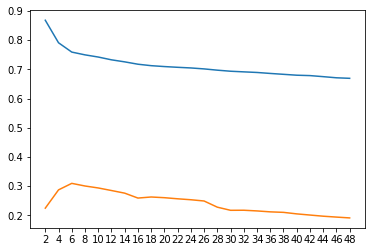

In [18]:
#vamos a gráficar los scores de train y test con plt.plot

plt.plot(np.mean(train_scores,axis=1))
plt.plot(np.mean(test_scores,axis=1))
plt.xticks(np.arange(24),n);

Sabiendo que en un principio estabamos en overfitting (gran diferencia entre el score de entrenamiento y el score de test), traté de variar el parámetro para ver si esto mejoraba. Gracias a la Curva de Validación podemos ver que cuando aumentamos el parametro al comienzo la curva de test mejora (la naranja), sin embargo después comienza a disminuir y tiene un pique. El mejor parámetro que puedo elegir es aprox: 6 vecinos. Logré que el score de test mejore en ese punto pero sigue existiendo un gran trecho entre ambos scores, lo cual tenemos que seguir buscando otro modelo. Seguimos con un problema de varianza.

Cual es la idea de hacer esta curva de validación? una vez que diagnosticamos en que situación esta nuestro modelo debemos complejificarlo o simplificarlo (underfitting o overfitting). Fijarse en los parámetros de control de cada algoritmo. Por ej., en el caso de Laso() tengo el aplha (mientras mas aumentamos mas lo simplificamos, mientras mas lo reducimos mas lo complejificamos). Depende de cada algoritmo. Se llaman hiperparametros (no se entrenan de forma automática sino que los elijo yo.

De forma general: la Curva de Validación es muy útil cuando usamos un modelo que tiene parámetros para ver si con el mismo modelo podemos arreglar el problema en el que estamos. De forma general, hay que buscar el máximo del score del test, eso nos va a decir cuál es el mejor valor del parámetro para elegir nuestro modelo.

La Curva de Aprendizaje nos habla más de si tenemos una buena cantidad de datos y si nuestro modelo ha podido aprender de estos.

In [19]:
#Lo que hace esta curva es evaluar cómo se comporta el modelo con pocos datos y con el máximo de datos que tenemos.
#Mientras más mejora el score en funcion de la cantidad de datos eso es realmente lo que llamamos aprender.

from sklearn.model_selection import learning_curve

lc = learning_curve(KNeighborsRegressor(n_neighbors=6),X,y,cv=5)
samples, train, test = lc[0], lc[1], lc[2]

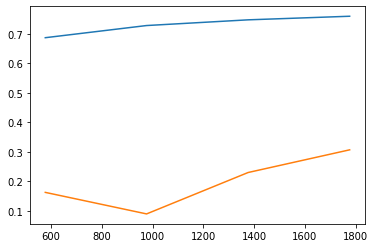

In [20]:
plt.plot(samples[1:],np.mean(train,axis=1)[1:])
plt.plot(samples[1:],np.mean(test,axis=1)[1:])

Acá vemos que el modelo KNeighborsRegressor va aprendiendo pero que éste no ha terminado de aprender (color naranja).
Este algoritmo es muy bueno pero cae en la maldición de la dimensionalidad. Si estamos en dimensión alta este algoritmo consume muchos datos. 

El modelo aún está aprendiendo, sin embargo no tenemos como obtener datos adicionales.

Como solucionar el overfitting y el underfitting?

Viarianza Alta:

Conseguir más ejemplos.
Reducir cantidad de features.
Aumentar coeficiente de regularización.


Bias Alto:

Más features.
Modelo más complejo.


Mal resultado general:

Probar otro algoritmo/familia de modelos, quizás las hipotesis del modelo no son cumplidad por tu dataset